# Chemical-Disease Relation (CDR) Tutorial

In this example, we'll be writing an application to extract *mentions of* **chemical-induced-disease relationships** from Pubmed abstracts, as per the [BioCreative CDR Challenge](http://www.biocreative.org/resources/corpora/biocreative-v-cdr-corpus/).  This tutorial will show off some of the more advanced features of Snorkel, so we'll assume you've followed the Intro tutorial.

Let's start by reloading from the last notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession

session = SnorkelSession()

In [2]:
from snorkel.models import candidate_subclass

ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

train_cands = session.query(ChemicalDisease).filter(ChemicalDisease.split == 0).all()
dev_cands = session.query(ChemicalDisease).filter(ChemicalDisease.split == 1).all()
print train_cands

[ChemicalDisease(Span("fusidic acid", sentence=62, chars=[67,78], words=[12,13]), Span("inflammatory bowel disease", sentence=62, chars=[105,130], words=[19,21])), ChemicalDisease(Span("Lidocaine-induced", sentence=21, chars=[0,16], words=[0,0]), Span("cardiac asystole", sentence=21, chars=[18,33], words=[1,2])), ChemicalDisease(Span("alpha-methyldopa", sentence=16, chars=[36,51], words=[6,6]), Span("hypotensive", sentence=16, chars=[4,14], words=[1,1])), ChemicalDisease(Span("naloxone", sentence=16, chars=[84,91], words=[12,12]), Span("hypotensive", sentence=16, chars=[4,14], words=[1,1])), ChemicalDisease(Span("Suxamethonium", sentence=24, chars=[0,12], words=[0,0]), Span("fasciculations", sentence=24, chars=[41,54], words=[5,5])), ChemicalDisease(Span("lidocaine", sentence=23, chars=[183,191], words=[29,29]), Span("bradyarrhythmias", sentence=23, chars=[105,120], words=[16,16])), ChemicalDisease(Span("Lithium", sentence=43, chars=[0,6], words=[0,0]), Span("hypertension", sentence=43

# Part III: Writing LFs

This tutorial features some more advanced LFs than the intro tutorial, with more focus on distant supervision and dependencies between LFs.

### Distant supervision approaches

We'll use the [Comparative Toxicogenomics Database](http://ctdbase.org/) (CTD) for distant supervision. The CTD lists chemical-condition entity pairs under three categories: therapy, marker, and unspecified. Therapy means the chemical treats the condition, marker means the chemical is typically present with the condition, and unspecified is...unspecified. We can write LFs based on these categories.

In [3]:
import bz2
from six.moves.cPickle import load

with bz2.BZ2File('data/ctd.pkl.bz2', 'rb') as ctd_f:
    ctd_unspecified, ctd_therapy, ctd_marker = load(ctd_f)

In [4]:
def cand_in_ctd_unspecified(c):
    return 1 if c.get_cids() in ctd_unspecified else 0

def cand_in_ctd_therapy(c):
    return 1 if c.get_cids() in ctd_therapy else 0

def cand_in_ctd_marker(c):
    return 1 if c.get_cids() in ctd_marker else 0

In [5]:
def LF_in_ctd_unspecified(c):
    return -1 * cand_in_ctd_unspecified(c)

def LF_in_ctd_therapy(c):
    return -1 * cand_in_ctd_therapy(c)

def LF_in_ctd_marker(c):
    return cand_in_ctd_marker(c)

### Text pattern approaches

Now we'll use some LF helpers to create LFs based on indicative text patterns. We came up with these rules by using the viewer to examine training candidates and noting frequent patterns.

In [6]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'

def LF_induce(c):
    return 1 if re.search(r'{{A}}.{0,20}induc.{0,20}{{B}}', get_tagged_text(c), flags=re.I) else 0

causal_past = ['induced', 'caused', 'due']
def LF_d_induced_by_c(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + '.{0,9}(by|to).{0,50}', 1)
def LF_d_induced_by_c_tight(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + ' (by|to) ', 1)

def LF_induce_name(c):
    return 1 if 'induc' in c.chemical.get_span().lower() else 0     

causal = ['cause[sd]?', 'induce[sd]?', 'associated with']
def LF_c_cause_d(c):
    return 1 if (
        re.search(r'{{A}}.{0,50} ' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)
        and not re.search('{{A}}.{0,50}(not|no).{0,20}' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)
    ) else 0

treat = ['treat', 'effective', 'prevent', 'resistant', 'slow', 'promise', 'therap']
def LF_d_treat_c(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1)
def LF_c_treat_d(c):
    return rule_regex_search_btw_AB(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1)
def LF_treat_d(c):
    return rule_regex_search_before_B(c, ltp(treat) + '.{0,50}', -1)
def LF_c_treat_d_wide(c):
    return rule_regex_search_btw_AB(c, '.{0,200}' + ltp(treat) + '.{0,200}', -1)

def LF_c_d(c):
    return 1 if ('{{A}} {{B}}' in get_tagged_text(c)) else 0

def LF_c_induced_d(c):
    return 1 if (
        ('{{A}} {{B}}' in get_tagged_text(c)) and 
        (('-induc' in c[0].get_span().lower()) or ('-assoc' in c[0].get_span().lower()))
        ) else 0

def LF_improve_before_disease(c):
    return rule_regex_search_before_B(c, 'improv.*', -1)

pat_terms = ['in a patient with ', 'in patients with']
def LF_in_patient_with(c):
    return -1 if re.search(ltp(pat_terms) + '{{B}}', get_tagged_text(c), flags=re.I) else 0

uncertain = ['combin', 'possible', 'unlikely']
def LF_uncertain(c):
    return rule_regex_search_before_A(c, ltp(uncertain) + '.*', -1)

def LF_induced_other(c):
    return rule_regex_search_tagged_text(c, '{{A}}.{20,1000}-induced {{B}}', -1)

def LF_far_c_d(c):
    return rule_regex_search_btw_AB(c, '.{100,5000}', -1)

def LF_far_d_c(c):
    return rule_regex_search_btw_BA(c, '.{100,5000}', -1)

def LF_risk_d(c):
    return rule_regex_search_before_B(c, 'risk of ', 1)

def LF_develop_d_following_c(c):
    return 1 if re.search(r'develop.{0,25}{{B}}.{0,25}following.{0,25}{{A}}', get_tagged_text(c), flags=re.I) else 0

procedure, following = ['inject', 'administrat'], ['following']
def LF_d_following_c(c):
    return 1 if re.search('{{B}}.{0,50}' + ltp(following) + '.{0,20}{{A}}.{0,50}' + ltp(procedure), get_tagged_text(c), flags=re.I) else 0

def LF_measure(c):
    return -1 if re.search('measur.{0,75}{{A}}', get_tagged_text(c), flags=re.I) else 0

def LF_level(c):
    return -1 if re.search('{{A}}.{0,25} level', get_tagged_text(c), flags=re.I) else 0

def LF_neg_d(c):
    return -1 if re.search('(none|not|no) .{0,25}{{B}}', get_tagged_text(c), flags=re.I) else 0

WEAK_PHRASES = ['none', 'although', 'was carried out', 'was conducted',
                'seems', 'suggests', 'risk', 'implicated',
               'the aim', 'to (investigate|assess|study)']

WEAK_RGX = r'|'.join(WEAK_PHRASES)

def LF_weak_assertions(c):
    return -1 if re.search(WEAK_RGX, get_tagged_text(c), flags=re.I) else 0

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


### Composite LFs

The following LFs take some of the strongest distant supervision and text pattern LFs, and combine them to form more specific LFs. These LFs introduce some obvious dependencies within the LF set, which we will model later.

In [7]:
def LF_ctd_marker_c_d(c):
    return LF_c_d(c) * cand_in_ctd_marker(c)

def LF_ctd_marker_induce(c):
    return (LF_c_induced_d(c) or LF_d_induced_by_c_tight(c)) * cand_in_ctd_marker(c)

def LF_ctd_therapy_treat(c):
    return LF_c_treat_d_wide(c) * cand_in_ctd_therapy(c)

def LF_ctd_unspecified_treat(c):
    return LF_c_treat_d_wide(c) * cand_in_ctd_unspecified(c)

def LF_ctd_unspecified_induce(c):
    return (LF_c_induced_d(c) or LF_d_induced_by_c_tight(c)) * cand_in_ctd_unspecified(c)

### Rules based on context hierarchy

These last two rules will make use of the context hierarchy. The first checks if there is a chemical mention much closer to the candidate's disease mention than the candidate's chemical mention. The second does the analog for diseases.

In [8]:
def LF_closer_chem(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find chemical closer than @dist/2 in either direction
    sent = c.get_parent()
    closest_other_chem = float('inf')
    for i in range(dis_end, min(len(sent.words), dis_end + dist / 2)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return -1
    for i in range(max(0, dis_start - dist / 2), dis_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return -1
    return 0

def LF_closer_dis(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find chemical disease than @dist/8 in either direction
    sent = c.get_parent()
    for i in range(chem_end, min(len(sent.words), chem_end + dist / 8)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Disease' and cid != sent.entity_cids[dis_start]:
            return -1
    for i in range(max(0, chem_start - dist / 8), chem_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Disease' and cid != sent.entity_cids[dis_start]:
            return -1
    return 0

### Running the LFs on the training set

In [9]:
LFs = [
    LF_c_cause_d,
    LF_c_d,
    LF_c_induced_d,
    LF_c_treat_d,
    LF_c_treat_d_wide,
    LF_closer_chem,
    LF_closer_dis,
    LF_ctd_marker_c_d,
    LF_ctd_marker_induce,
    LF_ctd_therapy_treat,
    LF_ctd_unspecified_treat,
    LF_ctd_unspecified_induce,
    LF_d_following_c,
    LF_d_induced_by_c,
    LF_d_induced_by_c_tight,
    LF_d_treat_c,
    LF_develop_d_following_c,
    LF_far_c_d,
    LF_far_d_c,
    LF_improve_before_disease,
    LF_in_ctd_therapy,
    LF_in_ctd_marker,
    LF_in_patient_with,
    LF_induce,
    LF_induce_name,
    LF_induced_other,
    LF_level,
    LF_measure,
    LF_neg_d,
    LF_risk_d,
    LF_treat_d,
    LF_uncertain,
    LF_weak_assertions,
]

In [10]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [11]:
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%3%

CPU times: user 612 ms, sys: 24 ms, total: 636 ms
Wall time: 680 ms


<33x33 sparse matrix of type '<type 'numpy.int64'>'
	with 87 stored elements in Compressed Sparse Row format>

In [12]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_c_cause_d,0,0.060606,0.060606,0.030303
LF_c_d,1,0.151515,0.151515,0.030303
LF_c_induced_d,2,0.121212,0.121212,0.030303
LF_c_treat_d,3,0.000000,0.000000,0.000000
LF_c_treat_d_wide,4,0.000000,0.000000,0.000000
LF_closer_chem,5,0.151515,0.151515,0.090909
LF_closer_dis,6,0.060606,0.060606,0.060606
LF_ctd_marker_c_d,7,0.151515,0.151515,0.030303
LF_ctd_marker_induce,8,0.121212,0.121212,0.030303
LF_ctd_therapy_treat,9,0.000000,0.000000,0.000000


# Part IV: Training the generative model

As mentioned above, we want to include the dependencies between our LFs when training the generative model. Snorkel makes it easy to do this! `DependencySelector` runs a fast structure learning algorithm over the matrix of LF outputs to identify a set of likely dependencies. We can see that these match up with our prior knowledge. For example, it identified a "reinforcing" dependency between `LF_c_induced_d` and `LF_ctd_marker_induce`. Recall that we constructed the latter using the former.

In [13]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
len(deps)

261

In [14]:
deps

{(0, 3, 0),
 (0, 4, 0),
 (0, 9, 0),
 (0, 10, 0),
 (0, 12, 0),
 (0, 13, 0),
 (0, 14, 0),
 (0, 15, 0),
 (0, 16, 0),
 (0, 19, 0),
 (0, 22, 0),
 (0, 23, 0),
 (0, 25, 0),
 (0, 27, 0),
 (0, 29, 0),
 (0, 31, 0),
 (1, 2, 0),
 (1, 7, 0),
 (1, 8, 0),
 (1, 11, 0),
 (1, 21, 0),
 (1, 24, 0),
 (2, 7, 0),
 (2, 8, 0),
 (2, 11, 0),
 (2, 24, 0),
 (3, 4, 0),
 (3, 6, 0),
 (3, 9, 0),
 (3, 10, 0),
 (3, 12, 0),
 (3, 13, 0),
 (3, 14, 0),
 (3, 15, 0),
 (3, 16, 0),
 (3, 18, 0),
 (3, 19, 0),
 (3, 22, 0),
 (3, 23, 0),
 (3, 25, 0),
 (3, 26, 0),
 (3, 27, 0),
 (3, 28, 0),
 (3, 29, 0),
 (3, 30, 0),
 (3, 31, 0),
 (3, 32, 0),
 (4, 6, 0),
 (4, 9, 0),
 (4, 10, 0),
 (4, 12, 0),
 (4, 13, 0),
 (4, 14, 0),
 (4, 15, 0),
 (4, 16, 0),
 (4, 18, 0),
 (4, 19, 0),
 (4, 22, 0),
 (4, 23, 0),
 (4, 25, 0),
 (4, 26, 0),
 (4, 27, 0),
 (4, 28, 0),
 (4, 29, 0),
 (4, 30, 0),
 (4, 31, 0),
 (4, 32, 0),
 (5, 17, 0),
 (5, 18, 0),
 (5, 20, 0),
 (5, 30, 0),
 (6, 9, 0),
 (6, 10, 0),
 (6, 12, 0),
 (6, 13, 0),
 (6, 14, 0),
 (6, 15, 0),
 (6, 16, 0),


In [15]:
deps = set()

Now we'll train the generative model, using the `deps` argument to account for the learned dependencies. We'll also model LF propensity here, unlike the intro tutorial. In addition to learning the accuracies of the LFs, this also learns their likelihood of labeling an example.

In [16]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(
    L_train, deps=deps, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0
)

Inferred cardinality: 2


In [17]:
train_marginals = gen_model.marginals(L_train)

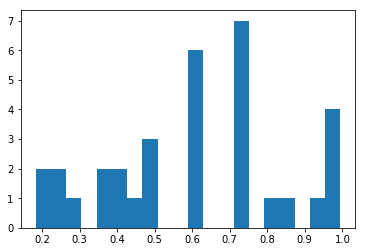

In [18]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [19]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.600043,0.4663,0.614783,0.277581
1,0.668051,0.5058,0.675254,0.339615
2,0.629690,0.4904,0.641779,0.308795
3,0.605404,0.4478,0.612019,0.271888
4,0.593771,0.4463,0.610670,0.271888
5,0.664801,0.5003,0.674980,0.329407
6,0.573103,0.4692,0.583691,0.266981
7,0.705595,0.5112,0.707892,0.353946
8,0.684800,0.5000,0.685659,0.347271
9,0.598247,0.4677,0.612876,0.284060


In [20]:
from snorkel.annotations import save_marginals
save_marginals(session, L_train, train_marginals)

Saved 33 marginals


### Checking performance against development set labels

Finally, we'll run the labeler on the development set, load in some external labels, then evaluate the LF performance. The external labels are applied via a small script for convenience. It maps the document-level relation annotations found in the CDR file to mention-level labels. Note that these will not be perfect, although they are pretty good. If we wanted to keep iterating, we could use `snorkel.lf_helpers.test_LF` against the dev set, or look at some false positive and false negative candidates.

In [28]:
from load_external_annotations import load_external_labels
load_external_labels(session, ChemicalDisease, split=1, annotator='gold')

(u'D013256', u'D009798')
(u'C081489', u'D004487')
(u'C081489', u'D004487')
(u'D017311', u'D004487')
(u'D017311', u'D004487')
(u'D017311', u'D004487')
(u'D017311', u'D004487')
(u'C081489', u'D006973')
(u'D017311', u'D006973')
(u'D013467', u'D034381')
(u'C081489', u'D006973')
(u'D017311', u'D006973')
(u'D000804', u'D006973')
(u'D013467', u'D015179')
(u'C081489', u'D006973')
(u'D017311', u'D006973')
(u'D013467', u'D018256')
[]
AnnotatorLabels created: 0


In [22]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

<17x1 sparse matrix of type '<type 'numpy.int64'>'
	with 17 stored elements in Compressed Sparse Row format>

In [23]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%05%



In [ ]:
_ = gen_model.score(session, L_dev, L_gold_dev)

In [ ]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])